# 3. Covid-19 samples from healthy, mild and severe patients
Chen ST, Park MD, Del Valle DM, Buckup M, Tabachnikova A, Thompson RC, et al. A shift in lung macrophage composition is associated with COVID-19 severity and recovery. Sci Transl Med. 2022;14:eabn5168

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.utils import convert_counts_to_df

# scCODA functions
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

2023-07-16 11:27:26.584234: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 11:27:26.587782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 11:27:26.664233: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 11:27:26.665498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 11:27:27.737037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------------------

## Read data

In [3]:
covid_counts = pd.read_csv("data/covid_counts.tsv", sep='\t')
covid = convert_counts_to_df(covid_counts, column_name="celltype")

------------

## Run Scanpro

In [4]:
scanpro_out = scanpro.scanpro(covid, clusters_col='celltype',
                              conds_col='group', samples_col='sample_new')
scanpro_out.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
B,0.003343,0.003503,0.012990,0.004005,2.593405,0.074765,0.106807
Epithelial,0.053652,0.130246,0.051903,0.118455,1.536041,0.215232,0.249978
Macrophages,0.750870,0.735290,0.512996,0.604316,1.491742,0.224980,0.249978
Mast,0.001064,0.002337,0.002220,0.001699,1.164873,0.311962,0.311962
NK,0.016425,0.008894,0.052466,0.017979,4.841923,0.007892,0.026306
Neutrophil,0.024418,0.000000,0.001204,0.055594,92.441438,0.000000,0.000000
Plasma,0.015818,0.000224,0.002150,0.050913,10.404122,0.000030,0.000152
T,0.117241,0.094594,0.325030,0.137097,3.081910,0.045872,0.084251
mDC,0.014860,0.023776,0.030831,0.008876,2.984785,0.050550,0.084251


In [5]:
scanpro_out.results.to_csv("results/covid_scanpro_rep.tsv", sep="\t")

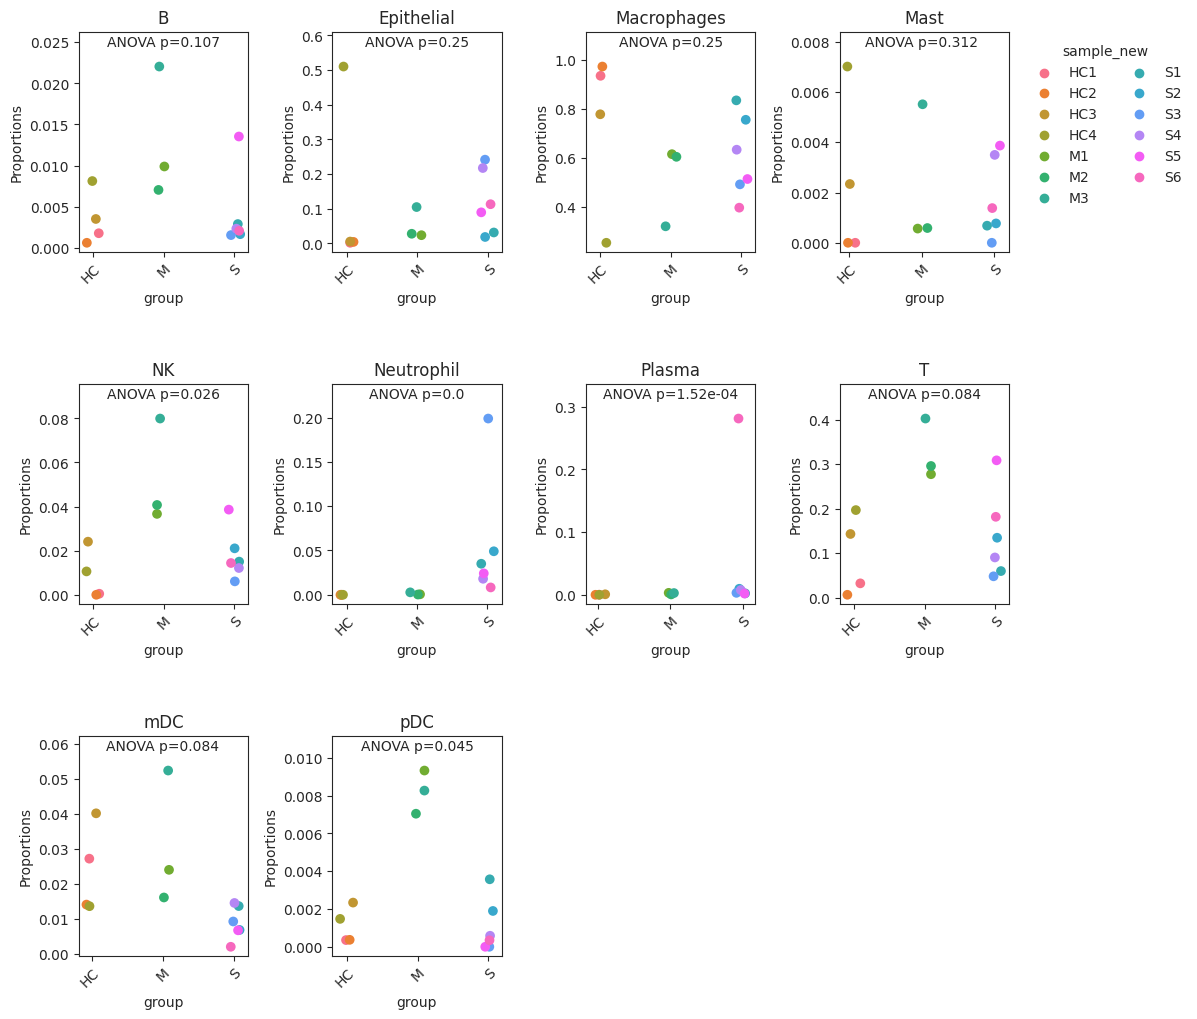

In [6]:
scanpro_out.plot(n_columns=4, save=f"{FIG_PATH}/covid19_logit.pdf")

### Without replicates

In [7]:
scanpro_out_norep = scanpro.scanpro(covid, clusters_col='celltype',
                                    conds_col='group')
scanpro_out_norep.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 12.57 seconds


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,p_values
clusters,,,,,
B,0.003343,0.001372,0.007502,0.001958,1.349471e-01
Epithelial,0.053652,0.061720,0.026265,0.045819,2.991314e-01
Macrophages,0.750870,0.850207,0.599225,0.727359,2.411694e-02
Mast,0.001064,0.000523,0.000415,0.000592,4.832450e-01
NK,0.016425,0.003145,0.036964,0.015301,7.049451e-03
Neutrophil,0.024418,0.000000,0.000249,0.038975,2.567539e-09
Plasma,0.015818,0.000034,0.001086,0.023123,3.773859e-06
T,0.117241,0.051069,0.285230,0.118617,3.177709e-03
mDC,0.014860,0.019081,0.019148,0.007420,2.816998e-01


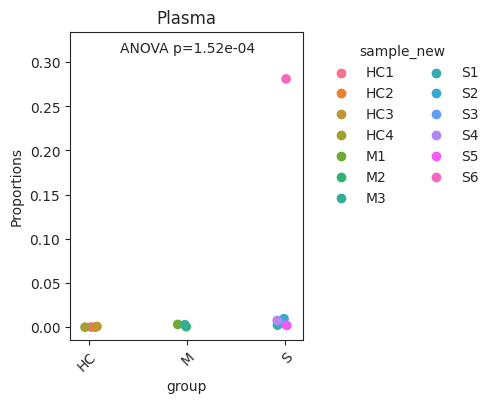

In [10]:
scanpro_out.plot(clusters=['Plasma'])

In [9]:
scanpro_out_norep.results.to_csv("results/covid_scanpro_norep.tsv", sep="\t")

-----------

## Propeller

In [11]:
%%R -i covid -o propeller_results
library(speckle)

propeller_results = propeller(clusters = covid$celltype, sample = covid$sample_new, group = covid$group)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has > 2 levels, ANOVA will be performed


In [12]:
propeller_results

,BaselineProp,PropMean.HC,PropMean.M,PropMean.S,Fstatistic,P.Value,FDR
Neutrophil,0.024418,-0.000000,0.001204,0.055594,34.534717,3.546468e-07,0.000004
Plasma,0.015818,0.000224,0.002150,0.050913,8.718137,2.056673e-03,0.010283
pDC,0.002310,0.001134,0.008210,0.001066,5.785273,1.052218e-02,0.034935
NK,0.016425,0.008894,0.052466,0.017979,5.391241,1.397389e-02,0.034935
T,0.117241,0.094594,0.325030,0.137097,3.155124,6.468749e-02,0.129375
mDC,0.014860,0.023776,0.030831,0.008876,2.484229,1.090338e-01,0.167374
B,0.003343,0.003503,0.012990,0.004005,2.394586,1.171617e-01,0.167374
Epithelial,0.053652,0.130246,0.051903,0.118455,1.813467,1.901866e-01,0.237733
Macrophages,0.750870,0.735290,0.512996,0.604316,1.620740,2.239111e-01,0.248790
Mast,0.001064,0.002337,0.002220,0.001699,0.692073,5.127128e-01,0.512713


In [13]:
propeller_results.to_csv("results/covid_propeller_rep.tsv", sep="\t")

----------

## scCODA

In [14]:
covid_counts

,sample,sample_new,group,disease,hasnCoV,B,Epithelial,Macrophages,Mast,NK,Neutrophil,Plasma,T,mDC,pDC
0,C100,HC3,HC,N,N,9,13,1998,6,62,0,2,367,103,6
1,C141,M1,M,Y,N,35,83,2177,2,130,2,11,981,85,33
2,C142,M2,M,Y,N,24,94,2060,2,139,1,2,1008,55,24
3,C143,S2,S,Y,N,28,307,12721,13,357,826,162,2268,116,31
4,C143,S2,S,Y,Y,0,2,44,0,0,3,0,4,0,1
5,C144,M3,M,Y,N,8,38,116,2,29,1,1,146,19,3
6,C145,S1,S,Y,N,33,355,9372,8,172,401,26,680,156,40
7,C145,S1,S,Y,Y,1,13,457,0,6,11,1,23,5,2
8,C146,S3,S,Y,N,2,227,469,0,6,207,4,48,7,0
9,C146,S3,S,Y,Y,0,85,166,0,2,50,0,14,5,0


In [15]:
# With replicates
sccoda_data = dat.from_pandas(covid_counts, covariate_columns=["sample_new", "sample", "group", "disease", "hasnCoV"])

# Without replicates
counts_merged = covid_counts.groupby("group").sum(numeric_only=True).reset_index()
sccoda_data_norep = dat.from_pandas(counts_merged, covariate_columns=["group"])

### With replicates

In [16]:
sccoda_model = mod.CompositionalAnalysis(sccoda_data, formula="group", reference_cell_type="automatic")
sccoda_results = sccoda_model.sample_hmc()

Automatic reference selection! Reference cell type set to Macrophages
Zero counts encountered in data! Added a pseudocount of 0.5.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-07-16 11:29:30.614853: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2da0168830 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-16 11:29:30.614922: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/20000 [00:00<?, ?it/s]2023-07-16 11:29:30.686174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-16 11:29:31.419096: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20000/20000 [01:56<00:00, 171.94it/s]


MCMC sampling finished. (148.787 sec)
Acceptance rate: 57.1%


In [17]:
sccoda_out = sccoda_results.credible_effects().to_frame(name="credible_effect")
sccoda_out.to_csv("results/covid_sccoda_rep.tsv", sep="\t")
sccoda_out

credible_effect
Covariate  Cell Type                   
group[T.M] B                      False
           Epithelial             False
           Macrophages            False
           Mast                   False
           NK                     False
           Neutrophil             False
           Plasma                 False
           T                      False
           mDC                    False
           pDC                    False
group[T.S] B                      False
           Epithelial             False
           Macrophages            False
           Mast                   False
           NK                     False
           Neutrophil              True
           Plasma                 False
           T                      False
           mDC                    False
           pDC                    False

### Without replicates

In [18]:
credeff_list = []
for _ in range(10):
    sccoda_model_norep = mod.CompositionalAnalysis(sccoda_data_norep, formula="group", reference_cell_type="automatic")
    sccoda_results_norep = sccoda_model_norep.sample_hmc()
    credeff_list.append(sccoda_results_norep.credible_effects())

Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:35<00:00, 208.99it/s]


MCMC sampling finished. (120.848 sec)
Acceptance rate: 73.7%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:20<00:00, 249.14it/s]


MCMC sampling finished. (102.464 sec)
Acceptance rate: 38.5%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:27<00:00, 228.13it/s]


MCMC sampling finished. (110.537 sec)
Acceptance rate: 44.4%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:24<00:00, 235.94it/s]


MCMC sampling finished. (110.424 sec)
Acceptance rate: 53.7%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:36<00:00, 208.28it/s]


MCMC sampling finished. (123.066 sec)
Acceptance rate: 48.5%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:37<00:00, 205.36it/s]


MCMC sampling finished. (123.632 sec)
Acceptance rate: 86.9%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:27<00:00, 229.39it/s]


MCMC sampling finished. (110.596 sec)
Acceptance rate: 0.0%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:32<00:00, 216.72it/s]


MCMC sampling finished. (118.217 sec)
Acceptance rate: 80.9%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:22<00:00, 241.38it/s]


MCMC sampling finished. (105.435 sec)
Acceptance rate: 39.6%
Automatic reference selection! Reference cell type set to Mast
Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [01:23<00:00, 240.78it/s]


MCMC sampling finished. (105.830 sec)
Acceptance rate: 78.1%


In [19]:
# Collect credible effects
all_credeff = pd.concat(credeff_list)
pct_credeff = all_credeff.groupby(all_credeff.index.names).mean().to_frame("pct_credible_effect") * 100
pct_credeff

pct_credible_effect
Covariate  Cell Type                       
group[T.M] B                           10.0
           Epithelial                  10.0
           Macrophages                 10.0
           Mast                         0.0
           NK                           0.0
           Neutrophil                   0.0
           Plasma                       0.0
           T                           20.0
           mDC                          0.0
           pDC                         10.0
group[T.S] B                           10.0
           Epithelial                   0.0
           Macrophages                  0.0
           Mast                         0.0
           NK                          10.0
           Neutrophil                  10.0
           Plasma                      10.0
           T                           10.0
           mDC                         10.0
           pDC                         10.0

In [20]:
pct_credeff.to_csv("results/covid_sccoda_norep.tsv", sep="\t")